In [1]:
import pandas as pd
import geopandas as gpd
from utils import processor
from scipy import stats

### Process GWIC data

In [26]:
# Get gwicids and associated metadata
gwic_filename = './data/missoula_valley_monitored_wells.csv'
gwicids = pd.read_csv('./data/mso_monitoring_wells_list.csv')['gwicid'].values
all_metadata = gpd.read_file('~/MEGA/business/adaptivehydro/projects/Missoula_City/Aquifer_Sustainability_Study/data/GWAAMON_Wells/Shapefile/GWAAMON_Wells.shp')
df_meta = all_metadata.loc[all_metadata['gwicid'].isin(gwicids)]
df_meta.to_csv('./data/gwic_site_metadata.csv', index=False)

Processing data for well 151179
Processing data for well 151189
Processing data for well 157214
Processing data for well 151101
Processing data for well 67037
Processing data for well 151191
Processing data for well 157208
Processing data for well 69402
Processing data for well 151081
Processing data for well 151061
Processing data for well 151204
Processing data for well 151161
Processing data for well 150967
Processing data for well 151190
Processing data for well 151188
Processing data for well 151143
Processing data for well 164350
Processing data for well 274392
Processing data for well 136400
Processing data for well 151203
Processing data for well 156566
Processing data for well 157207
Processing data for well 157209
Processing data for well 157211
Processing data for well 209148
Processing data for well 209157
Processing data for well 209254
Processing data for well 209255


<Axes: xlabel='time'>

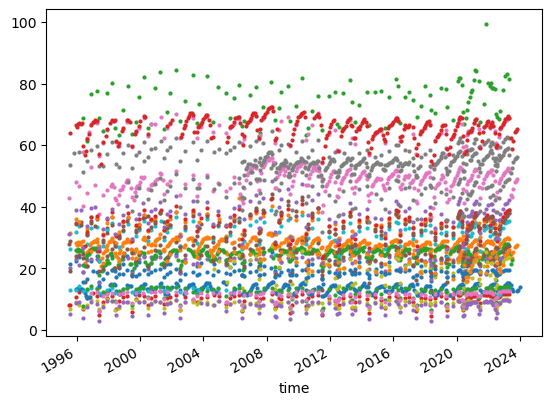

In [18]:
# Retrieve GWIC data
GWIC = processor.GWIC(gwicids)
gwic_data = GWIC.get_all_data(filename=gwic_filename, check_file=True)
gwic_data.plot(kind='line', style='o', legend=False, markersize=2)

### Process USGS streamflow data

<Axes: xlabel='time'>

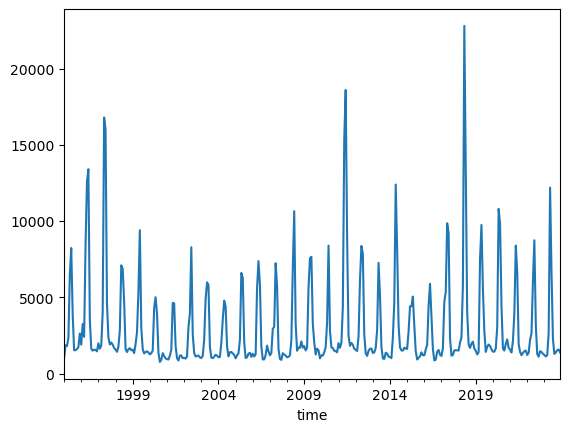

In [19]:
# Retrieve USGS data
clk_fk_avb_mso = '12340500'
usgs_filename = './data/clark_fk_above_missoula_q.csv'
USGS = processor.USGS(clk_fk_avb_mso)
usgs_data = USGS.get_all_data(filename=usgs_filename, check_file=True)
usgs_data.plot(kind='line', legend=False)

### Impute groundwater data to fill gaps

<Axes: xlabel='time'>

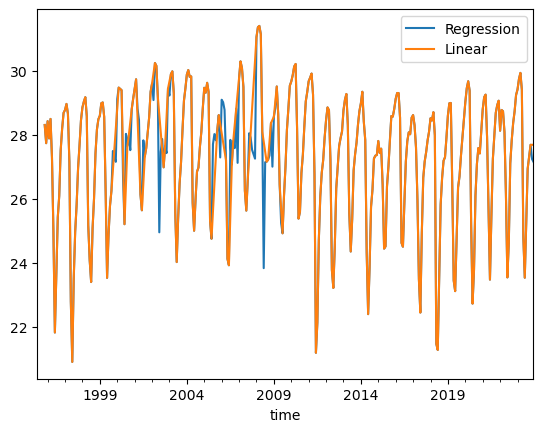

In [20]:
df = pd.concat([usgs_data, gwic_data], axis=1, join='inner')
Imputer = processor.Imputer(df)
df_reg = Imputer.q_and_doy_regression()
df_lin = Imputer.linear()
df_reg.to_csv('./data/missoula_valley_wells_imputed_qreg.csv')
df_lin.to_csv('./data/missoula_valley_wells_imputed_lin.csv')
df_reg.iloc[:, 2].plot(label='Regression', legend=True)
df_lin.iloc[:, 2].plot(label='Linear', legend=True)

### Build dynamic variables

In [21]:
# Standardize streamflow data
reg_method = 'lin'  # 'lin' or 'qreg'
reg_fname = './data/missoula_valley_wells_imputed_' + reg_method + '.csv'
if reg_method == 'lin':
    if 'df_lin' not in globals():
        df_lin = pd.read_csv(reg_fname, index_col=0)
    df_norm = df_lin.copy()
elif reg_method == 'qreg':
    if 'df_reg' not in globals():
        df_reg = pd.read_csv(reg_fname, index_col=0)
    df_norm = df_reg.copy()
df_norm['Q'] = stats.zscore(df_norm['Q'])
df_norm.index = pd.to_datetime(df_norm.index)
# shift index to the beginning of the month
df_norm.index = df_norm.index.shift(-1, freq='MS')

In [22]:
# Standardize City pumping data and add to df_norm
pumping_data = pd.read_csv('./data/mso_monthly_pumping_rates.csv')
pumping_data.index = pd.to_datetime(pumping_data['yrmo'], format='%b %Y')
pumping_data['pumping_rate'] = stats.zscore(pumping_data['vol_Mg'])
df_norm = pd.concat([pumping_data['pumping_rate'], df_norm], axis=1, join='inner')

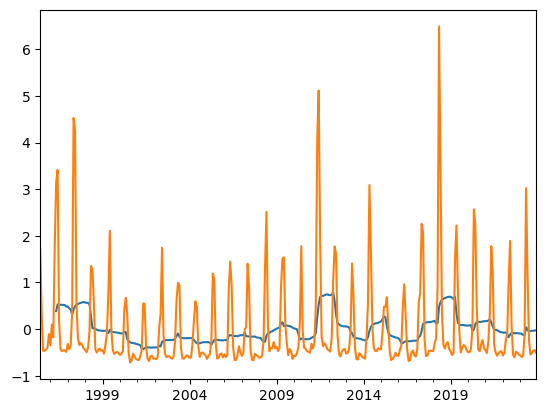

In [23]:
# Moving window for pumping and discharge data
window = 12 
# window labels are right edge of window index (see center=False in rolling)
df_norm['Q_win'] = df_norm['Q'].rolling(window=window).mean()
df_norm['pumping_rate_win'] = df_norm['pumping_rate'].rolling(window=window).mean()
df_norm['Q_win'].plot()
df_norm['Q'].plot()
df_norm.columns
df_norm.to_csv('./data/dynamic_variables_norm.csv')

### Build static variables

In [28]:
df_meta.columns

Index(['gwicid', 'site_name', 'latitude', 'longitude', 'geomethod',
       'datum_latl', 'date_latlo', 'altitude', 'method_alt', 'datum_alti',
       'date_altit', 'township', 'range', 'qsection', 'county', 'state',
       'drainage_b', 'addition_s', 'block', 'lot', 'certofsurv', 'parcel',
       'assessortr', 'geocode', 'site_type', 'total_dept', 'swl', 'date_compl',
       'how_drille', 'drilling_c', 'driller_na', 'driller_li', 'driller__1',
       'driller_fi', 'verified_t', 'abandoned_', 'date_aband', 'status',
       'flowing', 'depth_wate', 'aquifer', 'priority', 'well_use',
       'welluse_pr', 'field_visi', 'samples', 'swl_meas', 'network',
       'calc_loc', 'ver_loc', 'report_lin', 'all_water_', 'yield_gpm',
       'pumping_wa', 'dnrc_water', 'geometry'],
      dtype='object')

In [29]:
# Select static variables from meta data
svars = ['gwicid', 'latitude', 'longitude', 'altitude', 'total_dept', 'swl']
if 'df_meta' not in globals():
    df_meta = pd.read_csv('./data/gwic_site_metadata.csv')
df_svars = df_meta[svars]
df_svars = df_svars.set_index('gwicid')

In [30]:
# Create static variables based on location
df_pts = pd.read_csv('./data/input_output_locations.csv', index_col='desc')
gdf_pts = gpd.GeoDataFrame(df_pts, 
                           geometry=gpd.points_from_xy(df_pts.longitude, 
                                                       df_pts.latitude),
                           crs="EPSG:4326")
gdf_pts = gdf_pts.to_crs(epsg=32100)
gdf_svars = gpd.GeoDataFrame(df_svars, 
                           geometry=gpd.points_from_xy(df_svars.longitude, 
                                                       df_svars.latitude),
                           crs="EPSG:4326")
gdf_svars = gdf_svars.to_crs(epsg=32100)
df_dist = gdf_svars.geometry.apply(lambda x: gdf_pts.distance(x))
df_svars = pd.concat([df_svars, df_dist], axis=1, join='inner')

In [31]:
# Create static ksat variable from SSURGO
# https://www.nrcs.usda.gov/sites/default/files/2022-08/SSURGO-Metadata-Table-Column-Descriptions-Report.pdf
shp_path = './data/bbox.shp'
prop = 'ksat_r'
ssurgo = processor.SSURGO(shp_path, gdf_svars)
df_soil = ssurgo.get_all_data(prop)
df_svars = pd.concat([df_svars, df_soil[prop]], axis=1, join='inner')
df_svars.to_csv('./data/static_variables.csv')

In [32]:
# Normalize static variables between 0 and 1
df_svars_norm = df_svars.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)
df_svars_norm.to_csv('./data/static_variables_norm.csv')